# Estimating Shelter Animal Outcomes Workbook

In this workbook, I will use data from Austin Animal Shelter, Texas, to see if one can use classification and regression modelling in order to estimate the outcome of any dog or cat who finds themselves in a shelter.

I will start by importing all relevant libraries and files.

## Import

In [455]:
## Import libraries

import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split

from sklearn import svm
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.svm import SVR
import seaborn as sns
import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

In [456]:
## Import csv's

intake = pd.read_csv('Austin_Animal_Center_Intakes.csv')
outcome = pd.read_csv('Austin_Animal_Center_Outcomes.csv')

In [457]:
intake[intake['Animal Type'] == 'Dog'].head()

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color
0,A786884,*Brock,01/03/2019 04:19:00 PM,01/03/2019 04:19:00 PM,2501 Magin Meadow Dr in Austin (TX),Stray,Normal,Dog,Neutered Male,2 years,Beagle Mix,Tricolor
1,A706918,Belle,07/05/2015 12:59:00 PM,07/05/2015 12:59:00 PM,9409 Bluegrass Dr in Austin (TX),Stray,Normal,Dog,Spayed Female,8 years,English Springer Spaniel,White/Liver
2,A724273,Runster,04/14/2016 06:43:00 PM,04/14/2016 06:43:00 PM,2818 Palomino Trail in Austin (TX),Stray,Normal,Dog,Intact Male,11 months,Basenji Mix,Sable/White
4,A682524,Rio,06/29/2014 10:38:00 AM,06/29/2014 10:38:00 AM,800 Grove Blvd in Austin (TX),Stray,Normal,Dog,Neutered Male,4 years,Doberman Pinsch/Australian Cattle Dog,Tan/Gray
5,A743852,Odin,02/18/2017 12:46:00 PM,02/18/2017 12:46:00 PM,Austin (TX),Owner Surrender,Normal,Dog,Neutered Male,2 years,Labrador Retriever Mix,Chocolate


In [458]:
outcome['Outcome Type'].value_counts()

Adoption           59105
Transfer           38376
Return to Owner    22143
Euthanasia          8776
Died                1240
Rto-Adopt            778
Disposal             602
Missing               70
Relocate              25
Name: Outcome Type, dtype: int64

In [459]:
intake['Intake Condition'].value_counts()

Normal      113193
Injured       7238
Sick          5581
Nursing       3948
Aged           445
Other          238
Medical        128
Feral          119
Pregnant        86
Neonatal        85
Behavior        35
Space            4
Name: Intake Condition, dtype: int64

# Lists

I will categorise a dogs breed, size and colour and a cats breed, pattern and colour. This will mean that each category will have multiple data points and will allow for better foresight as we can also include colours or breeds that have not yet visited the shelter into our model.

### Dog Categorised

The dog breeds include: Companions, Herding dogs, Hounds, Terriers, Working dogs, Sporting dogs, Bully breed dogs and Racing dogs.

In order to decide which breed belongs in which category, I used a website called 'dogtime' (https://dogtime.com/dog-breeds/groups) to categorise the vast majority. But, I also noticed dogs like the boston terrier are closer in appearance and size to the english bulldog and pugs than terriers and hence belonged in companions. Also, I noticed there were a lot of working dogs, so I created the 'Bully breed' category. Bull breeds tend to have a negative reputation for being 'dangerous' and some are even banned in certain countries, hence I want to see what difference this makes to a dogs adoptability. 

In [460]:
## Dog breed lists

Companions = ['Chow Chow','Alaskan Klee Kai', 'Mexican Hairless', 'Lowchen', 'Standard Poodle','Japanese Chin','Coton De Tulear', 'Cavalier Span','Bruss Griffon', 'Dachshund Stan', 'Old English Bulldog', 'Dalmatian', 'American Eskimo', 'Schipperke', 'Havanese', 'Keeshond', 'English Bulldog','Bulldog', 'Lhasa Apso','Eng Toy Spaniel','Chinese Crested','Dachshund Wirehair', 'Dachshund Longhair','Miniature Pinscher','Chihuahua Longhair','Maltese','Shih Tzu', 'Pekingese','Finnish Spitz', 'Papillon','Bichon Frise','Toy Poodle','Boston Terrier', 'Chihuahua Shorthair','Dachshund','Miniature Poodle','Pembroke Welsh Corgi','French Bulldog','Swedish Vallhund','Pug','Cardigan Welsh Corgi','Pomeranian','Shiba Inu',]
Herding_dogs = ['Spanish Water Dog','Bouv Flandres', 'Belgian Tervuren', 'Beauceron', 'Entlebucher', 'Queensland Heeler','Canaan Dog', 'Briard', 'Australian Kelpie', 'Dutch Sheepdog', 'English Shepherd', 'Dutch Shepherd', 'Belgian Sheepdog','Shetland Sheepdog','Picardy Sheepdog', 'German Shepherd','Belgian Malinois', 'Bearded Collie','Collie Rough','Border Collie',  'Australian Shepherd','Australian Cattle Dog','Collie Smooth','Old English Sheepdog', ]
Hound_dogs = ['Irish Wolfhound', 'Rhod Ridgeback', 'Grand Basset Griffon Vendeen', 'Otterhound', 'Pbgv', 'Harrier', 'Podengo Pequeno','Norwegian Elkhound', 'Basenji', 'Swiss Hound', 'English Coonhound','Afghan Hound','Pharaoh Hound','Ibizan Hound', 'English Foxhound', 'American Foxhound', 'Treeing Walker Coonhound','Basset Hound', 'Beagle','Plott Hound','Redbone Hound','Bloodhound','Bluetick Hound',]
Terriers = ['Dandie Dinmont','Glen Of Imaal', 'Affenpinscher','Feist','Lakeland Terrier','Bedlington Terr', 'Sealyham Terr','Australian Terrier', 'Toy Fox Terrier', 'Smooth Fox Terrier','Airedale Terrier','Patterdale Terr','Wire Hair Fox Terrier', 'West Highland','Soft Coated Wheaten Terrier', 'Rat Terrier','Welsh Terrier', 'Skye Terrier','Parson Russell Terrier','Scottish Terrier','Tibetan Terrier','Border Terrier','Cairn Terrier','Yorkshire Terrier','Miniature Schnauzer','Norfolk Terrier','Jack Russell Terrier','Irish Terrier', 'Manchester Terrier', 'Silky Terrier','Norwich Terrier', ]
Working_dogs = ['Boxer','Schnauzer Giant','Great Pyrenees', 'Great Dane', 'Newfoundland', 'St. Bernard Smooth Coat','St. Bernard Rough Coat', 'Leonberger', 'Landseer','Kangal', 'Hovawart', 'Akbash','Treeing Tennesse Brindle', 'Treeing Cur','Jindo', 'Port Water Dog','Catahoula', 'Kuvasz', 'Carolina Dog', 'Blue Lacy','Samoyed', 'Greater Swiss Mountain Dog','German Pinscher', 'Chinese Sharpei', 'Anatol Shepherd','Bernese Mountain Dog', 'Standard Schnauzer','Akita', 'Alaskan Malamute','Alaskan Husky','Siberian Husky',]
Sporting_dogs = ['Weimaraner','Boykin Span','Sussex Span', 'Black Mouth Cur','Chesa Bay Retr', 'Wirehaired Pointing Griffon','Spinone Italiano', 'Wirehaired Vizsla','Clumber Spaniel','English Cocker Spaniel', 'Irish Setter', 'Field Spaniel','Tibetan Spaniel', 'Gordon Setter', 'Welsh Springer Spaniel','German Wirehaired Pointer','German Shorthair Pointer','Brittany', 'English Setter', 'English Pointer','Cocker Spaniel', 'English Springer Spaniel', 'Golden Retriever', 'Pointer', 'Flat Coat Retriever','Vizsla','Nova Scotia Duck Tolling Retriever','Labrador Retriever', ]
Bully_breeds = ['Presa Canario', 'Boerboel', 'Neapolitan Mastiff','Spanish Mastiff','American Bulldog','Bullmastiff', 'Bull Terrier Miniature', 'Dogo Argentino','Tibetan Mastiff','Doberman Pinsch', 'Bull Terrier', 'Mastiff','Staffordshire','Rottweiler','American Staffordshire Terrier', 'American Pit Bull Terrier','Pit Bull','Cane Corso','Dogue De Bordeaux',]
Racing_dogs = ['Saluki','Greyhound','Whippet','Italian Greyhound',]

The dog size categories are: toy, small, medium, large and giant.

These dogs are categorised by weight, with some moving a size up due to their height differences of dogs with the same weight.

In [461]:
## Dog breed sizes

toy = ['Tibetan Spaniel', 'Patterdale Terr', 'Norwich Terrier', 'Silky Terrier','Jack Russell Terrier','Norfolk Terrier','Miniature Schnauzer','Cairn Terrier','Yorkshire Terrier','Border Terrier','Parson Russell Terrier','West Highland','Wire Hair Fox Terrier', 'Smooth Fox Terrier','Australian Terrier', 'Toy Fox Terrier', 'Sealyham Terr','Lakeland Terrier','Affenpinscher','Pug', 'Pomeranian','Chihuahua Shorthair','Dachshund','Toy Poodle','Bichon Frise','Papillon','Shih Tzu', 'Pekingese','Maltese','Lhasa Apso','Eng Toy Spaniel','Chinese Crested','Dachshund Wirehair', 'Dachshund Longhair','Miniature Pinscher', 'Bruss Griffon', 'Dachshund Stan', 'Cavalier Span','Coton De Tulear', 'Japanese Chin','Chihuahua Longhair', 'Lowchen',]
small = ['Italian Greyhound','Cocker Spaniel', 'Manchester Terrier', 'Irish Terrier', 'Tibetan Terrier','Scottish Terrier','Skye Terrier','Welsh Terrier', 'Rat Terrier','Bedlington Terr', 'Feist','Dandie Dinmont','Beagle','Basenji', 'Shetland Sheepdog','Shiba Inu','Swedish Vallhund','French Bulldog','Cardigan Welsh Corgi','Pembroke Welsh Corgi','Miniature Poodle','Boston Terrier', 'Finnish Spitz', 'Havanese', 'Schipperke', 'American Eskimo', 'Alaskan Klee Kai', ]
medium = ['Whippet','American Staffordshire Terrier', 'Staffordshire','Bull Terrier Miniature', 'Nova Scotia Duck Tolling Retriever','English Springer Spaniel', 'Brittany', 'Welsh Springer Spaniel','Field Spaniel','English Cocker Spaniel', 'Sussex Span', 'Boykin Span','Standard Schnauzer','Chinese Sharpei', 'German Pinscher', 'Blue Lacy','Carolina Dog', 'Jindo', 'Treeing Cur','Treeing Tennesse Brindle', 'Soft Coated Wheaten Terrier','Glen Of Imaal', 'Basset Hound', 'Ibizan Hound', 'Pharaoh Hound','Swiss Hound', 'Norwegian Elkhound', 'Pbgv', 'Grand Basset Griffon Vendeen', 'Border Collie',  'Australian Shepherd', 'Australian Kelpie', 'Canaan Dog', 'Australian Cattle Dog','Queensland Heeler','Spanish Water Dog','Keeshond',  'Old English Bulldog', 'English Bulldog','Bulldog', 'Mexican Hairless',]
large = ['Greyhound','Saluki','American Pit Bull Terrier','Pit Bull','Bull Terrier', 'Doberman Pinsch', 'Dogo Argentino', 'Chow Chow','Boxer','Schnauzer Giant','Weimaraner','Rhod Ridgeback', 'Labrador Retriever', 'Flat Coat Retriever', 'Pointer', 'Golden Retriever', 'English Pointer','English Setter', 'German Shorthair Pointer','German Wirehaired Pointer','Gordon Setter', 'Irish Setter','Clumber Spaniel','Vizsla','Wirehaired Vizsla','Spinone Italiano', 'Wirehaired Pointing Griffon','Chesa Bay Retr', 'Black Mouth Cur','Alaskan Malamute','Alaskan Husky','Siberian Husky','Akita', 'Samoyed', 'Catahoula', 'Port Water Dog','Hovawart', 'Airedale Terrier','Bluetick Hound','Bloodhound','Redbone Hound','Plott Hound','Treeing Walker Coonhound','American Foxhound', 'English Foxhound', 'Afghan Hound','English Coonhound','Podengo Pequeno','Harrier', 'Collie Smooth','Old English Sheepdog', 'Bearded Collie','Collie Rough','Picardy Sheepdog','Belgian Sheepdog','Dutch Shepherd', 'English Shepherd', 'Dutch Sheepdog', 'German Shepherd','Belgian Malinois', 'Briard', 'Entlebucher', 'Beauceron', 'Belgian Tervuren', 'Bouv Flandres', 'Standard Poodle','Dalmatian',]
giant = ['Cane Corso','Dogue De Bordeaux','Rottweiler','Mastiff','American Bulldog','Bullmastiff', 'Tibetan Mastiff','Boerboel', 'Neapolitan Mastiff','Spanish Mastiff','Presa Canario', 'Irish Wolfhound', 'Great Dane', 'Newfoundland', 'Great Pyrenees', 'St. Bernard Smooth Coat','St. Bernard Rough Coat', 'Leonberger', 'Landseer','Kangal', 'Bernese Mountain Dog', 'Anatol Shepherd','Greater Swiss Mountain Dog','Kuvasz', 'Akbash','Otterhound', ]

The dog colour categories are: dark, light, red-orange, blue-grey and merle.

Dark and light are dogs who do not fit in the other categories and hence depend on which side of the colour spectrum they fit.

In [462]:
## Dog color lists

dark_dog = ['Black Tiger','Black', 'Brown', 'Brown Brindle', 'Tricolor','Chocolate','Brown Tiger','Black Smoke',  'Yellow Brindle', 'Black Brindle']
light_dog = ['White','Cream', 'Tan', 'Sable', 'Fawn', 'Yellow','Buff']
red_orange_dog = ['Ruddy','Gold', 'Red', 'Liver', 'Apricot','Red Tick', 'Orange','Liver Tick']
blue_grey_dog = ['Agouti','Blue', 'Gray', 'Silver', 'Blue Tick', 'Blue Smoke', 'Blue Cream', 'Blue Tiger']
merle_dog = ['Blue Merle', 'Red Merle', 'Brown Merle','Calico']

### Cat Categorised

The cat colour categories are: dark, light, red-orange, blue-grey and black-orange-white (category created for torties and calicos).

In [463]:
## Cat color lists

dark_cat = ['Black', 'Brown', 'Black Smoke', 'Chocolate', 'Sable' ]
light_cat = ['Fawn', 'White', 'Cream', 'Seal', 'Lynx', 'Flame', 'Buff','Tan' ]
red_orange_cat = ['Red Tick','Orange', 'Yellow','Agouti', 'Red' ,'Apricot', 'Pink' ]
blue_grey_cat = ['Blue', 'Gray','Blue Cream', 'Lilac', 'Silver', 'Silver Lynx', 'Blue Smoke' ]
black_orange_white_cat = [ 'Tortie','Calico','Torbie','Tricolor']

The cat breed categories are: short hair, long hair and hairless.

Cat breeds are harder to categorise as they are not as different as dog breeds. The differences in breeds tend to be mostly in colour, pattern (which both have their own category, we will see pattern later), face shape and fur length. I decided to categorise cat breeds based on their fur length.

In [464]:
## Cat breed lists

short_hair = ['Ocicat','Havana Brown', 'Colorpoint','American Wirehair', 'Oriental Sh','Scottish Fold', 'Bombay', 'Cornish Rex','Burmese', 'Siamese', 'Japanese Bobtail', 'Chartreux', 'Devon Rex','Bengal','Tonkinese', 'Abyssinian', 'Munchkin Shorthair', 'Exotic Shorthair', 'British Shorthair','American Curl Shorthair', 'Pixiebob Shorthair', 'Snowshoe', 'Domestic Shorthair', 'American Shorthair', 'Russian Blue','Manx']
long_hair = ['Javanese', 'Cymric','Angora','Balinese', 'Persian', 'Birman', 'Ragdoll', 'Turkish Angora', 'Maine Coon', 'Domestic Medium Hair','Norwegian Forest Cat', 'Himalayan','Turkish Van', 'Balinese', 'Domestic Longhair', 'Munchkin Longhair']
hairless = ['Sphynx']

# Checking data

In [465]:
outcome['Breed'].value_counts()

Domestic Shorthair Mix                   31823
Domestic Shorthair                        8922
Pit Bull Mix                              8700
Labrador Retriever Mix                    7122
Chihuahua Shorthair Mix                   6371
                                         ...  
Australian Shepherd/Australian Kelpie        1
Pug/Miniature Pinscher                       1
Bruss Griffon/Chihuahua Longhair             1
Chihuahua Longhair/Italian Greyhound         1
Silkie Mix                                   1
Name: Breed, Length: 2684, dtype: int64

In [466]:
intake['Animal Type'].value_counts()

Dog          73810
Cat          49648
Other         7004
Bird           614
Livestock       24
Name: Animal Type, dtype: int64

In [467]:
outcome.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,05/08/2019 06:20:00 PM,05/08/2019 06:20:00 PM,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,07/18/2018 04:02:00 PM,07/18/2018 04:02:00 PM,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A821648,NaN,08/16/2020 11:38:00 AM,08/16/2020 11:38:00 AM,08/16/2019,Euthanasia,NaN,Other,Unknown,1 year,Raccoon,Gray
3,A720371,Moose,02/13/2016 05:59:00 PM,02/13/2016 05:59:00 PM,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
4,A674754,NaN,03/18/2014 11:47:00 AM,03/18/2014 11:47:00 AM,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby


# Dog cat split

I will now split dog and cat intakes and outcomes into their own lists. This will allow me to clean and prepare them separately, ready for modelling.

In [468]:
intake_dog = intake[intake['Animal Type'] == 'Dog']
outcome_dog = outcome[outcome['Animal Type'] == 'Dog']
intake_cat = intake[intake['Animal Type'] == 'Cat']
outcome_cat = outcome[outcome['Animal Type'] == 'Cat']

In [469]:
outcome_cat['Outcome Type'].value_counts()

Adoption           23077
Transfer           21229
Return to Owner     2295
Euthanasia          2056
Died                 738
Rto-Adopt            164
Disposal              84
Missing               35
Relocate               4
Name: Outcome Type, dtype: int64

## Prior Cleaning EDA

I checked the data to see if any null values or anything that could cause issues could be present in the datasets.

### Intake

Name is not important for modelling and hence this column will be removed. There is only one null in sex upon intake, so this will be removed in cleaning.

In [470]:
## Check for nulls

intake.isna().sum()

Animal ID               0
Name                40308
DateTime                0
MonthYear               0
Found Location          0
Intake Type             0
Intake Condition        0
Animal Type             0
Sex upon Intake         1
Age upon Intake         0
Breed                   0
Color                   0
dtype: int64

### Outcome

Although there appears to be a lot of nulls in the outcome dataset, we will not be using the 'outcome subtype' column and will remove the rest of the nulls in the cleaning section.

In [610]:
outcome.isna().sum()

Animal ID               0
Name                40252
DateTime                0
MonthYear               0
Date of Birth           0
Outcome Type           24
Outcome Subtype     70829
Animal Type             0
Sex upon Outcome        1
Age upon Outcome       13
Breed                   0
Color                   0
dtype: int64

Through this, I learned that one animal can return to a shelter multiple times, which can cause problems when merging the intake and outcome datasets. As you can see below, one animal has returned to the Austin Animal Shelter 33 times.

In [471]:
## Some animals have escaped and returned multiple times

dupes = intake.groupby('Animal ID').count().sort_values('DateTime', ascending = False)
dupes[dupes['DateTime']>1].head()

,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color
Animal ID,,,,,,,,,,,
A721033,33,33,33,33,33,33,33,33,33,33,33
A718223,14,14,14,14,14,14,14,14,14,14,14
A718877,12,12,12,12,12,12,12,12,12,12,12
A706536,11,11,11,11,11,11,11,11,11,11,11
A717053,9,9,9,9,9,9,9,9,9,9,9


In [472]:
intake[intake['Animal ID']=='A664093'].head()

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color
19368,A664093,Katrina,10/13/2013 01:53:00 PM,10/13/2013 01:53:00 PM,Outside Jurisdiction,Owner Surrender,Normal,Dog,Spayed Female,5 years,Rottweiler Mix,Black/Tan


In [473]:
outcome[outcome['Animal ID']=='A664093'].head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
69876,A664093,Katrina,10/10/2013 12:31:00 PM,10/10/2013 12:31:00 PM,09/29/2008,Adoption,NaN,Dog,Spayed Female,5 years,Rottweiler Mix,Black/Tan
78781,A664093,Katrina,10/26/2013 11:00:00 AM,10/26/2013 11:00:00 AM,09/29/2008,Transfer,Partner,Dog,Spayed Female,5 years,Rottweiler Mix,Black/Tan


# Data Cleaning

## Functions

I have built functions to make cleaning the data easier. This will also be used later in the workbook to clean data provided about a single animal to make predictions.

### Intake function

This function drops an animals name, month when animal was taken in, location where it was found, breed, sex, colour, type and age when taken in (after categorisation).

It also turns the date and time when taken in into a datetime variable.

It then renames all columns.

In [474]:
## Clean intake function

def clean_intake(df):
    '''Function to clean the intake dataset
    
    parameters:
    - df: dataframe containing intake dataset
    
    output:
    clean intake dataset required for merging'''
    for i in ['Name', 'MonthYear', 'Found Location', 'Breed', 
              'Sex upon Intake', 'Color', 'Animal Type']:
        try:
            df.drop(i, axis = 1, inplace = True)
        except:
            print(f'{i} is done')
    
    df.dropna(inplace = True)
    
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    
    ## Drop age upon Intake as no longer useful.
    try:
        df.drop('Age upon Intake',axis = 1, inplace = True)
    except:
        print('Age upon Intake is done')
    
    ## Rename columns
    df.columns = ['Animal ID', 'DateTime Intake', 'Intake Type', 'Intake Condition']
    
    return df

### Outcome function

This function drops an animals name, month when it was found and age when an outcome has occured (after categorisation).

It also turns the date and time when animal was taken in, date and time when outcome has occured and date of birth into a datetime variable.

It changes adopted to fostered if fosters is the subtype before dropping the outcome subtype column.

Finally it renames all columns.

In [475]:
## Clean outcome function
def clean_outcome(df):
    '''Function to clean the outcome dataset
    
    parameters:
    - df: dataframe containing outcome dataset
    
    output:
    clean outcome dataset required for merging.'''
    for i in ['Name', 'MonthYear']:
        try:
            df.drop(i, axis = 1, inplace = True)
        except:
            print(f'{i} is done')
    
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    
    df['Date of Birth'] = pd.to_datetime(df['Date of Birth'])
    
    df['Age in days upon outcome'] = pd.DatetimeIndex(df['DateTime']).normalize() - df['Date of Birth']
    
    df.drop('Age upon Outcome', axis = 1, inplace = True)
    
    ## Change outcome type from adoption to foster if fostered
    df.loc[df['Outcome Subtype'] == 'Foster', 'Outcome Type'] = 'Foster'
    
    try:
        df.drop('Outcome Subtype', inplace = True, axis = 1)
    except:
        print('Outcome subtype dropped')
        
    return df

### Merger

The merger function merges the intake and outcome datasets using a function called pd.merge_asof(). In order to use this function all datapoints must be sorted by the DateTime values. The function then matches the intake and outcome data points by animal ID, making sure that the datetime dates match without overlapping or an animal being adopted before it has been taken to the shelter.

The merger function then drops any nulls, which removes any animals who have no record of being taken in and any animals with no record of leaving the shelter as they these are not useful to modelling.

This now allows us to calculate the age at which the animal appeared at the shelter and the time taken for its outcome to occur.

Finally, I drop any columns that are no longer useful.

In [476]:
## Merger function
def merger(intake_df, outcome_df):
    '''Function to merge the intake and outcome datasets.
    
    parameters:
    - intake_df: dataframe containing intake dataset
    - outcome_df: dataframe containing outcome dataset
    
    output:
    dataset containing intake and outcome data'''
    
    ## Sort intake by date
    intake_df.sort_values(by=['DateTime Intake','Animal ID'],inplace = True)
    
    ## Sort outcome by date
    outcome_df.sort_values(by=['DateTime','Animal ID'],inplace=True)
    
    ## merge so that dates combine with dog being found before ending up back in shelter and both intake dates don't pair with same outcome dates.
    train = pd.merge_asof(intake_df,outcome_df, by='Animal ID', left_on='DateTime Intake', right_on='DateTime',direction='forward')
    
    ## drop nulls (intakes without outcomes and vice versa)
    train.dropna(inplace = True)
    
    ## calculate age when animal turns up at shelter
    train['Age in days upon income'] = pd.DatetimeIndex(train['DateTime Intake']).normalize() - train['Date of Birth']
    train = train[train['Age in days upon income']>=datetime.timedelta(days=0)]
    
    ## calculate time taken for outcome to occur
    train['Time Spent in Shelter'] = train['Age in days upon outcome'] - train['Age in days upon income']
    
    ## drop useless columns
    try:
        train.drop('DateTime Intake', axis = 1, inplace = True)
    except:
        print('Datetime intake dropped')
        
    try:
        train.drop('DateTime', axis = 1, inplace = True)
    except:
        print('Datetime dropped')
        
    try:
        train.drop('Date of Birth', axis = 1, inplace = True)
    except:
        print('DoB dropped')

    
    return train

## Applying cleaning

Our functions above have allowed us to clean the data using a single line of code.

In [477]:
dog_merge = merger(clean_intake(intake_dog),clean_outcome(outcome_dog))
cat_merge = merger(clean_intake(intake_cat),clean_outcome(outcome_cat))

C:\Users\lhall\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-474-4ba9434fddff>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)
<ipython-input-474-4ba9434fddff>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DateTime'] = pd.to_datetime(df['DateTime'])
C:\Us

Below allowed me to check whether the cleaning and merging has been successful and check for any issues that may have occurred.

In [478]:
dog_merge['Outcome Type'].value_counts()

Adoption           30082
Return to Owner    19652
Transfer           15804
Foster              4817
Euthanasia          1806
Rto-Adopt            612
Died                 266
Disposal              41
Missing               28
Name: Outcome Type, dtype: int64

In [479]:
dog_merge.isnull().sum(axis = 0)

Animal ID                   0
Intake Type                 0
Intake Condition            0
Outcome Type                0
Animal Type                 0
Sex upon Outcome            0
Breed                       0
Color                       0
Age in days upon outcome    0
Age in days upon income     0
Time Spent in Shelter       0
dtype: int64

## Test Train Split

Prior to modelling, I split the dog and cat data sets into train and test sets.

In [480]:
# Test Train split all data sets

dog_train, dog_test = train_test_split(dog_merge, test_size = 0.3, random_state = 42)
cat_train, cat_test = train_test_split(cat_merge, test_size = 0.3, random_state = 42)

## Data cleaning on test and train

I created this function to clean the data in both dog and cat test and train sets separately.

The first line of action is creating new columns for neutered and mix, then removing the key words from the original columns.

Next, I made sure that the outcome types and intake conditions had enough datapoints in each category. This meant removing animals who had died, been disposed of, gone missing or have been relocated and categorising the intake conditions into: Medical, Behaviour, Other and Normal.

Finally, animals of unknown gender have been removed.

In [481]:
## Fix data
def fix_data(df):
    '''Function to create new columns and make changes from original data in the merged dataset.
    
    parameters:
    - df: dataframe containing merged dataset
    
    output:
    dataset with new columns'''
    ## Create a new column called Neutered which gives 1 if animal is spayed or neutered and 0 otherwise
    df['Neutered'] = np.where(df['Sex upon Outcome'].str.contains(r'Neutered'), 1,
                               np.where(df['Sex upon Outcome'].str.contains(r'Spayed'), 1,0))
    
    ## Remove neutered, spayed and intact from animals gender.
    df['Sex upon Outcome'].replace(r'Neutered\s', '', regex = True, inplace = True)
    df['Sex upon Outcome'].replace(r'Spayed\s', '', regex = True, inplace = True)
    df['Sex upon Outcome'].replace(r'Intact\s', '', regex = True, inplace = True)
    
    ## Create a new column called Mix which gives 1 if animal is a crossbreed and 0 if pedigree
    df['Mix'] = np.where(df['Breed'].str.contains(r'\sMix'), 1,
                                   np.where(df['Breed'].str.contains(r'\/[a-zA-Z\s]+'), 1,0))
    
    ## Remove the words Mix or secondary breed from breed.
    df['Breed'].replace(r'\sMix', '', regex = True, inplace = True)
    df['Breed'].replace(r'\/[a-zA-Z\s]+', '', regex = True, inplace = True)
    
    ## st bernards crosses appear as 'dog. bernard mix'. fix this so appears as 'dog mix'.
    df.loc[df['Breed'].str.contains(r'[^St].\sBernard\s[A-Za-z\s]+'), 'Breed'] = df.loc[df['Breed'].str.contains(r'[^St].\sBernard\s[A-Za-z\s]+'), 'Breed'].str.replace(r'.\sBernard\s[A-Za-z\s]+','')
        
    df['Outcome Type'].replace('Rto-Adopt','Return to Owner', inplace = True)
    try:
        df = df[~df['Outcome Type'].isin(['Died', 'Disposal', 'Missing', 'Relocate'])]
    except:
        print('No pets in this category')
    else:
        print('Pets removed')
        
    df['Intake Condition'] = np.where(df['Intake Condition'].isin(['Injured', 'Sick', 'Aged', 'Medical', 'Pregnant', 'Nursing', 'Neonatal']), 'Medical',
                                   np.where(df['Intake Condition'].isin(['Behavior', 'Feral']), 'Behavior',
                                            np.where(df['Intake Condition'].isin(['Other', 'Abandoned', 'Space']), 'Other',
                                                     np.where(df['Intake Condition'].isin(['Normal']), 'Normal', 'Unknown'))))
    try:
        df = df[~df['Sex upon Outcome'].isin(['Unknown'])]
    except:
        print('No pets in this category')
    else:
        print('Pets removed')
        
    return df

In [482]:
dog_train = fix_data(dog_train)
dog_test = fix_data(dog_test)
cat_train = fix_data(cat_train)
cat_test = fix_data(cat_test)

<ipython-input-481-6ac765b8664c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Neutered'] = np.where(df['Sex upon Outcome'].str.contains(r'Neutered'), 1,
C:\Users\lhall\anaconda3\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-481-6ac765b8664c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

Pets removed
Pets removed
Pets removed
Pets removed
Pets removed
Pets removed
Pets removed
Pets removed


## Fix dog colours and breeds

This function uses the lists defined in the list categories above and uses them to categorise the dogs and cats column values. It also removes any strange breed categories.

You will see this used again for the final function on data one provides.

In [483]:
def fix_dog_colour(df):
    '''Function to categorise column values from merged dataset.
    
    parameters:
    - df: dataframe containing merged dataset with new columns
    
    output:
    dataset with smaller value counts in each column'''
    try:
        df = df[~df['Breed'].isin(['Wolf Hybrid', 'Black', 'Unknown'])]
    except:
        print('No dogs in this category')
    else:
        print('Dogs removed')
    df['Breed Category'] = np.where(df['Breed'].isin(Companions), 'Companion',
                                   np.where(df['Breed'].isin(Herding_dogs), 'Herding',
                                            np.where(df['Breed'].isin(Hound_dogs), 'Hound',
                                                     np.where(df['Breed'].isin(Working_dogs), 'Working',
                                                              np.where(df['Breed'].isin(Sporting_dogs), 'Sporting',
                                                                       np.where(df['Breed'].isin(Bully_breeds), 'Bull',
                                                                                np.where(df['Breed'].isin(Racing_dogs), 'Racing',
                                                                                          np.where(df['Breed'].isin(Terriers), 'Terrier','Unknown'))))))))
    df['Size'] = np.where(df['Breed'].isin(toy), 'Toy',
                                   np.where(df['Breed'].isin(small), 'Small',
                                            np.where(df['Breed'].isin(medium), 'Medium',
                                                     np.where(df['Breed'].isin(large), 'Large',
                                                              np.where(df['Breed'].isin(giant), 'Giant','Unknown')))))
    
    df['Color'].replace(r'\/[a-zA-Z\s]+', '', regex = True, inplace = True)
    df['Color Category'] = np.where(df['Color'].isin(dark_dog), 'Dark',
                                   np.where(df['Color'].isin(light_dog), 'Light',
                                            np.where(df['Color'].isin(red_orange_dog), 'Red/Orangeish',
                                                     np.where(df['Color'].isin(blue_grey_dog), 'Blue/Greyish',
                                                              np.where(df['Color'].isin(merle_dog), 'Merle','Unknown')))))
    return df

## Fix cat colours and breeds

In [484]:
def fix_cat_colour(df):
    '''Function to categorise column values from merged dataset.
    
    parameters:
    - df: dataframe containing merged dataset with new columns
    
    output:
    dataset with smaller value counts in each column'''
    df['Breed Category'] = np.where(df['Breed'].isin(short_hair), 'Short Hair',
                                   np.where(df['Breed'].isin(long_hair), 'Long Hair',
                                            np.where(df['Breed'].isin(hairless), 'Hairless','Unknown')))
    
    ## Create a new column called Pattern which gives 2 color if animal has two colours, striped if tabby or tiger, point if siamese coloured and spotted if breed is ocicat
    df['Pattern'] = np.where(df['Color'].str.contains(r'\/[a-zA-Z\s]+'), '2 color',
                                   np.where(df['Color'].str.contains('Tabby'), 'Striped',
                                            np.where(df['Color'].str.contains('Tiger'), 'Striped',
                                                     np.where(df['Color'].str.contains('Point'), 'Point',
                                                              np.where(df['Color'].str.contains('Brindle'), 'Brindle',
                                                                       np.where(df['Color'].str.contains('Merle'), 'Merle','Solid'))))))
    df['Color'].replace(r'\/[a-zA-Z\s]+', '', regex = True, inplace = True)
    df['Color'].replace(r'\sTabby', '', regex = True, inplace = True)
    df['Color'].replace(r'\sTiger', '', regex = True, inplace = True)
    df['Color'].replace(r'\sPoint', '', regex = True, inplace = True)
    df['Color'].replace(r'\sBrindle', '', regex = True, inplace = True)
    df['Color'].replace(r'\sMerle', '', regex = True, inplace = True)
    
    df['Color Category'] = np.where(df['Color'].isin(dark_cat), 'Dark',
                                   np.where(df['Color'].isin(light_cat), 'Light',
                                            np.where(df['Color'].isin(red_orange_cat), 'Red/Orangeish',
                                                     np.where(df['Color'].isin(blue_grey_cat), 'Blue/Greyish',
                                                              np.where(df['Color'].isin(black_orange_white_cat), 'Black Orange White','Unknown')))))
    return df

In [485]:
dog_train = fix_dog_colour(dog_train)
dog_test = fix_dog_colour(dog_test)
cat_train = fix_cat_colour(cat_train)
cat_test = fix_cat_colour(cat_test)

Dogs removed
Dogs removed


<ipython-input-483-71e31c7c9ba9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Breed Category'] = np.where(df['Breed'].isin(Companions), 'Companion',
<ipython-input-483-71e31c7c9ba9>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Size'] = np.where(df['Breed'].isin(toy), 'Toy',
<ipython-input-483-71e31c7c9ba9>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

## Data Visualisation

In this section, I will visualise the data to look for patterns and better understand what patterns exist for the model to build on.

In [486]:
dog_train.head()

,Animal ID,Intake Type,Intake Condition,Outcome Type,Animal Type,Sex upon Outcome,Breed,Color,Age in days upon outcome,Age in days upon income,Time Spent in Shelter,Neutered,Mix,Breed Category,Size,Color Category
42883,A763555,Stray,Normal,Transfer,Dog,Female,Beagle,Tricolor,3164 days,3159 days,5 days,1,0,Hound,Small,Dark
33976,A742234,Public Assist,Normal,Return to Owner,Dog,Male,Yorkshire Terrier,Brown,2932 days,2925 days,7 days,1,1,Terrier,Toy,Dark
65359,A716669,Stray,Normal,Return to Owner,Dog,Female,Saluki,Tricolor,1903 days,1903 days,0 days,1,1,Racing,Large,Dark
48326,A775736,Stray,Normal,Return to Owner,Dog,Male,Pit Bull,Brown,1734 days,1731 days,3 days,0,1,Bull,Large,Dark
23850,A453083,Stray,Normal,Return to Owner,Dog,Female,Border Collie,Chocolate,3712 days,3712 days,0 days,1,1,Herding,Medium,Dark


In [487]:
dog_train['Outcome Type'].value_counts()

Adoption           21121
Return to Owner    14026
Transfer           10833
Foster              3352
Euthanasia          1241
Name: Outcome Type, dtype: int64

As you can see below, return to owner and transfer tends to occur faster than foster.

Most of the outcomes occur quickly, with a few (mostly fosters) taking a bit longer.

You can also notice that the only numeric points we have do not have a linear correlation, as the vast majority of points lie at the bottom. Hence, we may not be able to use linear or polynomial regression. We will have to try non linear regression techniques.

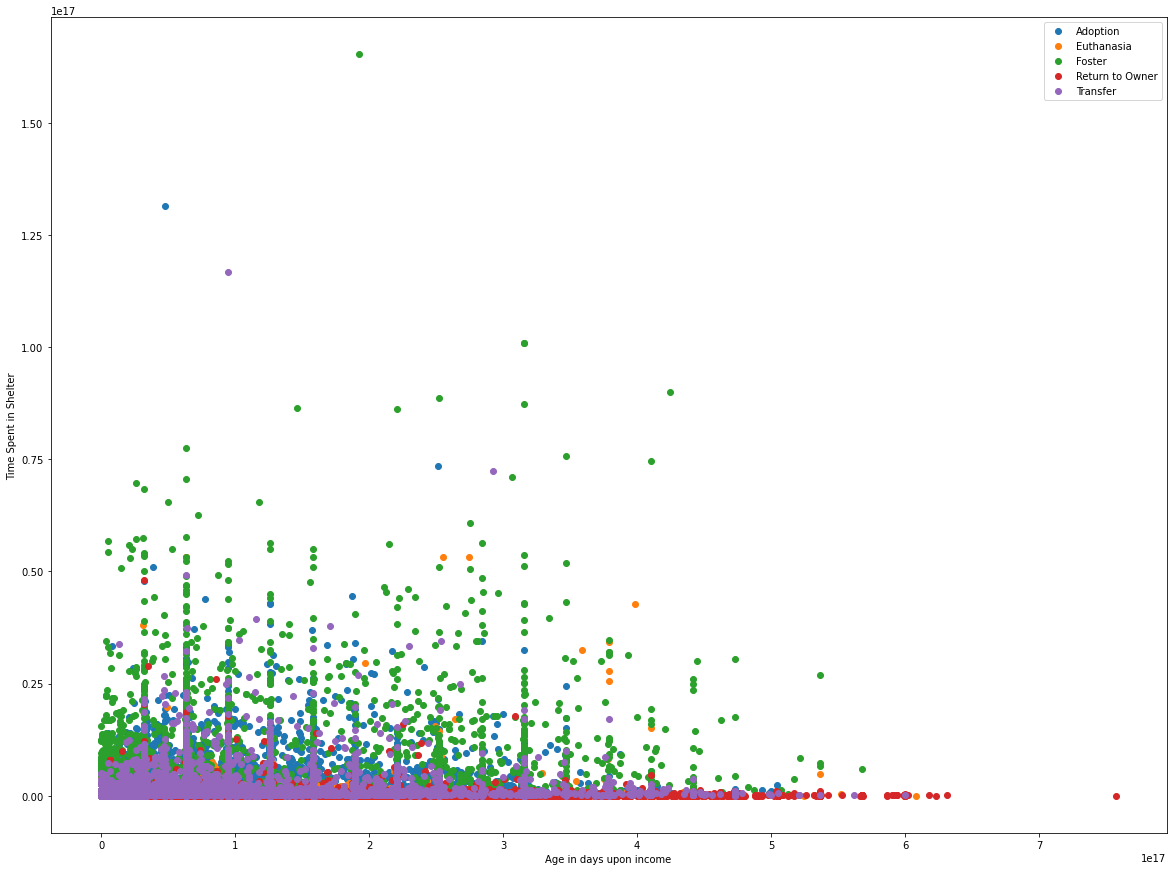

In [488]:
plt.figure(figsize=(20,15))
groups = dog_train.groupby('Outcome Type')
for name, group in groups:
    plt.plot(group["Age in days upon income"], group["Time Spent in Shelter"], marker="o", linestyle="", label=name)
plt.xlabel('Age in days upon income')
plt.ylabel('Time Spent in Shelter')
plt.legend()

As you can see, the majority of dogs who take the longest to be adopted are in the 'Bully Breeds' category (7).

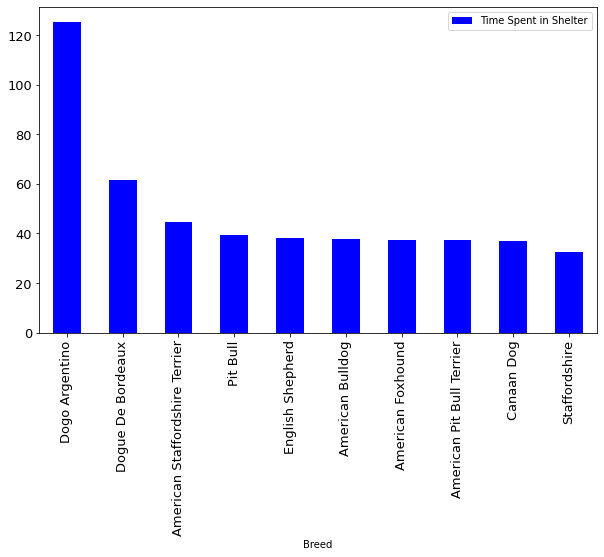

In [489]:
test_dog_train = dog_train.copy()
test_dog_train = test_dog_train[test_dog_train['Outcome Type'] == 'Adoption']
test_dog_train['Time Spent in Shelter'] = test_dog_train['Time Spent in Shelter'].dt.days
groups2 = test_dog_train[['Breed','Time Spent in Shelter']].groupby(['Breed']).mean().sort_values(by = 'Time Spent in Shelter', ascending = False).head(10)
ax = groups2.plot(kind='bar', figsize=(10,6), color="blue", fontsize=13)

On the opposite side, the dogs most quickly adopted, on average, are mostly in the companion category (4) with working and sporting in a close second (2).

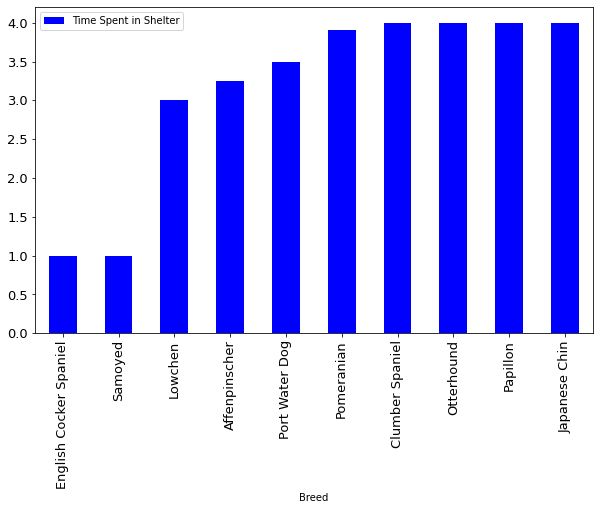

In [490]:
groups3 = test_dog_train[['Breed','Time Spent in Shelter']].groupby(['Breed']).mean().sort_values(by = 'Time Spent in Shelter', ascending = True).head(10)
ax = groups3.plot(kind='bar', figsize=(10,6), color="blue", fontsize=13)

## Modelling

Now that the data sets have the correct columns, I can now prepare them for modelling through dropping columns which are not useful for any modelling and one hot encoding the remaining string columns.

### Picking columns

Drop any remaining useless columns prior to modelling.

In [491]:
def column_drop(df):
    '''Function to drop columns from given dataset.
    
    parameters:
    - df: dataframe containing dataset with new columns, now categorised and split.
    
    output:
    dataset with smaller number of columns'''
    for i in ['Animal ID', 'Animal Type', 'Age in days upon outcome',
             'Breed', 'Color']:
        try:
            df.drop(i, axis = 1, inplace = True)
        except:
            print(f'{i} dropped')
        
    return df


In [492]:
dog_train = column_drop(dog_train)
dog_test = column_drop(dog_test)
cat_train = column_drop(cat_train)
cat_test = column_drop(cat_test)

In [493]:
dog_train['Intake Condition'].unique()

array(['Normal', 'Medical', 'Other', 'Behavior'], dtype=object)

### One hot encoding

One hot encode the dog and cat test and train string columns.

In [494]:
def dog_feature_eng(df):
    '''Function to one hot encode dog dataset.
    
    parameters:
    - df: dataframe of dog dataset
    
    output:
    dataset with more columns with 1, 0 values'''
    prefix_list = ['itype', 'icond', 'sex', 'bcat', 'size', 'ccat']
    j=0
    for i in ['Intake Type', 'Intake Condition', 'Sex upon Outcome', 'Breed Category', 'Size', 'Color Category']:
        df = pd.get_dummies(df, columns=[i], drop_first=True, prefix=prefix_list[j])
        j+=1
    
    return df

In [495]:
def cat_feature_eng(df):
    '''Function to one hot encode cat dataset.
    
    parameters:
    - df: dataframe of cat dataset
    
    output:
    dataset with more columns with 1, 0 values'''
    prefix_list = ['itype', 'icond', 'sex', 'bcat', 'patt', 'ccat']
    j=0
    for i in ['Intake Type', 'Intake Condition', 'Sex upon Outcome', 'Breed Category', 'Pattern', 'Color Category']:
        df = pd.get_dummies(df, columns=[i], drop_first=True, prefix=prefix_list[j])
        j+=1
    return df

In [496]:
dog_train = dog_feature_eng(dog_train)
dog_test = dog_feature_eng(dog_test)
cat_train = cat_feature_eng(cat_train)
cat_test = cat_feature_eng(cat_test)

Now I can turn the time column values into integers as number of days.

In [497]:
## Turning time deltas into numeric values for modelling
dog_train['Age in days upon income'] = dog_train['Age in days upon income'].dt.days
dog_train['Time Spent in Shelter'] = dog_train['Time Spent in Shelter'].dt.days
dog_test['Age in days upon income'] = dog_test['Age in days upon income'].dt.days
dog_test['Time Spent in Shelter'] = dog_test['Time Spent in Shelter'].dt.days

In [498]:
cat_train['Age in days upon income'] = cat_train['Age in days upon income'].dt.days
cat_train['Time Spent in Shelter'] = cat_train['Time Spent in Shelter'].dt.days
cat_test['Age in days upon income'] = cat_test['Age in days upon income'].dt.days
cat_test['Time Spent in Shelter'] = cat_test['Time Spent in Shelter'].dt.days

All the numeric value columns ready for scaling- will have no effect on one hot encoded columns.

I have made sure to miss out time spent in shelter, as this will not be used in the classification modelling and is what we want to estimate in our regression models.

In [499]:
## Scaling age column
scaler_dog_cols = ['Age in days upon income',
       'Neutered', 'Mix', 'itype_Euthanasia Request', 'itype_Owner Surrender',
       'itype_Public Assist', 'itype_Stray', 'icond_Medical', 'icond_Normal',
       'icond_Other', 'sex_Male', 'bcat_Herding', 'bcat_Hound', 'bcat_Racing',
       'bcat_Sporting', 'bcat_Terrier', 'bcat_Companion', 'bcat_Working',
       'size_Large', 'size_Medium', 'size_Small', 'size_Toy', 'ccat_Dark',
       'ccat_Light', 'ccat_Merle', 'ccat_Red/Orangeish']

In order to scale the numeric data, I have decided to use a standard scaler, as it gives better results than the min-max scaler.

In [501]:
scaler_dog = StandardScaler()

dog_train['Age in days upon income'] = scaler_dog.fit_transform(dog_train[scaler_dog_cols])
dog_test['Age in days upon income'] = scaler_dog.transform(dog_test[scaler_dog_cols])

In [502]:
scaler_cat_cols = ['Age in days upon income',
       'Neutered', 'Mix', 'itype_Euthanasia Request', 'itype_Owner Surrender',
       'itype_Public Assist', 'itype_Stray', 'icond_Medical', 'icond_Normal',
       'icond_Other', 'sex_Male', 'bcat_Long Hair', 'bcat_Short Hair',
       'patt_Brindle', 'patt_Point', 'patt_Solid', 'patt_Striped',
       'ccat_Blue/Greyish', 'ccat_Dark', 'ccat_Light', 'ccat_Red/Orangeish']

In [503]:
scaler_cat = StandardScaler()
cat_test['patt_Brindle'] = 0
cat_train['Age in days upon income'] = scaler_cat.fit_transform(cat_train[scaler_cat_cols])
cat_test['Age in days upon income'] = scaler_cat.transform(cat_test[scaler_cat_cols])

Final check before modelling begins.

In [504]:
cat_train

,Outcome Type,Age in days upon income,Time Spent in Shelter,Neutered,Mix,itype_Euthanasia Request,itype_Owner Surrender,itype_Public Assist,itype_Stray,icond_Medical,...,bcat_Long Hair,bcat_Short Hair,patt_Brindle,patt_Point,patt_Solid,patt_Striped,ccat_Blue/Greyish,ccat_Dark,ccat_Light,ccat_Red/Orangeish
34117,Transfer,0.186349,18,1,1,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
39399,Transfer,-0.476298,9,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
8061,Transfer,-0.324751,1,0,1,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
1088,Transfer,-0.325741,45,1,1,0,0,0,1,0,...,0,1,0,0,0,1,1,0,0,0
45403,Foster,-0.506013,106,1,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6304,Adoption,1.271941,2,1,1,0,1,0,0,0,...,0,1,0,0,0,1,0,1,0,0
45115,Transfer,-0.460450,10,1,1,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
38482,Adoption,-0.417858,6,1,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0
862,Euthanasia,1.634465,9,1,1,0,0,0,1,0,...,1,0,0,0,0,1,1,0,0,0


## Classification

### Dog

First we will start by using our classification model on our dog datasets.

Let us do a two outcome classification, the outcomes being: positive outcomes (adopted, returned to owner or fostered) or negative outcomes (being transferred or euthanised).

In order turn our outcome types into binary data, I used the following function.

In [505]:
## Turn outcome type into binary of positive and negative outcomes
def fix_y(df):
    '''Function to provide 2 outcomes for modelling
    
    parameters:
    - df: dataframe of dog or cat dataset
    
    output:
    dataset where outcome types have 1 or 0 values'''
    df['Outcome Type'] = df['Outcome Type'].map({'Adoption':1, 'Return to Owner':1, 'Transfer':0, 'Foster':1, 'Euthanasia':0})
    return df

Use the function on a copy of the original datasets to ensure that the cleaning required for this model does not carry over into future models.

In [506]:
X_dog_train = fix_y(dog_train.copy())
X_dog_test = fix_y(dog_test.copy())
X_cat_train = fix_y(cat_train.copy())
X_cat_test = fix_y(cat_test.copy())

Next I have split the train and test data sets into the x (columns we want to model on) and y (the actual outcomes for testing the accuracy of the model).

In [507]:
## Pick x and y
y_dog_train = X_dog_train['Outcome Type']
X_dog_train = X_dog_train[['Age in days upon income', 'Neutered', 'Mix',
       'itype_Euthanasia Request', 'itype_Owner Surrender',
       'itype_Public Assist', 'itype_Stray', 'icond_Medical', 'icond_Normal',
       'icond_Other', 'sex_Male', 'bcat_Herding', 'bcat_Hound', 'bcat_Racing',
       'bcat_Sporting', 'bcat_Terrier', 'bcat_Companion', 'bcat_Working',
       'size_Large', 'size_Medium', 'size_Small', 'size_Toy', 'ccat_Dark',
       'ccat_Light', 'ccat_Merle', 'ccat_Red/Orangeish']]

In [508]:
y_dog_test = X_dog_test['Outcome Type']
X_dog_test = X_dog_test[['Age in days upon income', 'Neutered', 'Mix',
       'itype_Euthanasia Request', 'itype_Owner Surrender',
       'itype_Public Assist', 'itype_Stray', 'icond_Medical', 'icond_Normal',
       'icond_Other', 'sex_Male', 'bcat_Herding', 'bcat_Hound', 'bcat_Racing',
       'bcat_Sporting', 'bcat_Terrier', 'bcat_Companion', 'bcat_Working',
       'size_Large', 'size_Medium', 'size_Small', 'size_Toy', 'ccat_Dark',
       'ccat_Light', 'ccat_Merle', 'ccat_Red/Orangeish']]

I tried many other models to see which provides the best accuracy scores and SVM appears to be the best model.

Hence, I have chosen an SVM model with these parameters using trial and error. I attempted to use grid search to find the optimal parameters, however, it took too much time and after waiting half a day, I never recieved anything.

In [509]:
## Modelling SVM
dog_model = SVC(gamma= 0.5             #0.5
              , kernel='rbf'
              , C= 0.1)                 #0.1)
dog_model.fit(X_dog_train, y_dog_train)

SVC(C=0.1, gamma=0.5)

In [510]:
## Predict on train
X_dog_train['y_pred'] = dog_model.predict(X_dog_train)

In [511]:
print(f"Train: {accuracy_score(X_dog_train['y_pred'], y_dog_train)}")

Train: 0.8168192513791944


In [512]:
## Predict on Test
X_dog_test['y_pred'] = dog_model.predict(X_dog_test)

This model is not overfitted as train is very similar to test, making this a good model so far.

In [513]:
print(f"Test: {accuracy_score(X_dog_test['y_pred'], y_dog_test)}")

Test: 0.8141040462427745


In [514]:
precision_score(y_dog_test,X_dog_test['y_pred'])

0.8249149437320074

In [515]:
recall_score(y_dog_test, X_dog_test['y_pred'])

0.9589291146942501

Test accuracy =  0.8141040462427745
Test precision =  0.8249149437320074
Test recall =  0.9589291146942501


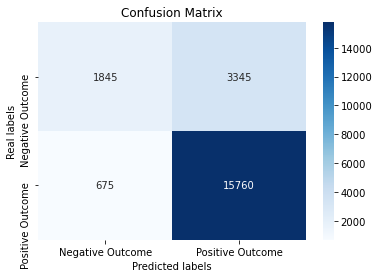

In [516]:
#Define confusion matrix and metrics
def produce_confusion(positive_label, negative_label, df, y_pred_name, y_real_name):
    '''Function to create a confusion matrix and provide accuracy, precision and recall values.
    
    parameters:
    - positive_label: string value of name of positive outcome
    - negative_label: string value of name of negative outcome
    - df: dataframe of dog or cat dataset
    - y_pred_name: series containing predicited y values from model
    - y_real_name: series containing actual y values from data
    
    output:
    confusion matrix and precision, accuracy and recall values'''
    
    #Set pred to 0 or 1 depending on whether it's higher than the cut_off point.
    df['pred_binary'] = df[y_pred_name]
    
    #Build the CM
    cm = confusion_matrix(y_real_name, df['pred_binary'])  
    
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='g', cmap = plt.cm.Blues); 

    # labels, title, ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('Real labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels([negative_label, positive_label])
    ax.yaxis.set_ticklabels([negative_label, positive_label]);

    print('Test accuracy = ', accuracy_score(y_real_name, df['pred_binary']))
    print('Test precision = ', precision_score(y_real_name, df['pred_binary']))
    print('Test recall = ', recall_score(y_real_name, df['pred_binary']))

    return accuracy_score(y_real_name, df['pred_binary'])
accuracy = produce_confusion('Positive Outcome', 'Negative Outcome', X_dog_test, 'y_pred', y_dog_test)

As the use of this model will affect the lives of dogs and the chance they have of a better life, we want to keep the number of false negatives as low as possible (we don't want to euthanise or send away dogs with a chance at finding a home). 

Luckily, as you can see from the confusion matrix above, the number of dogs with a predicted negative outcome, who have actually had a positive outcome are a lot lower than the other predictions. Hence, I believe this makes this SVM model, fit for purpose.

In [517]:
for i in [X_dog_train, X_dog_test]:
    try:
        i.drop('y_pred', axis = 1, inplace = True)
    except:
        print('y_pred dropped')

In [518]:
for i in [X_dog_train, X_dog_test]:
    try:
        i.drop('pred_binary', axis = 1, inplace = True)
    except:
        print('pred_binary dropped')

pred_binary dropped


In [519]:
X_dog_train.columns

Index(['Age in days upon income', 'Neutered', 'Mix',
       'itype_Euthanasia Request', 'itype_Owner Surrender',
       'itype_Public Assist', 'itype_Stray', 'icond_Medical', 'icond_Normal',
       'icond_Other', 'sex_Male', 'bcat_Herding', 'bcat_Hound', 'bcat_Racing',
       'bcat_Sporting', 'bcat_Terrier', 'bcat_Companion', 'bcat_Working',
       'size_Large', 'size_Medium', 'size_Small', 'size_Toy', 'ccat_Dark',
       'ccat_Light', 'ccat_Merle', 'ccat_Red/Orangeish'],
      dtype='object')

In [520]:
X_dog_test.columns

Index(['Age in days upon income', 'Neutered', 'Mix',
       'itype_Euthanasia Request', 'itype_Owner Surrender',
       'itype_Public Assist', 'itype_Stray', 'icond_Medical', 'icond_Normal',
       'icond_Other', 'sex_Male', 'bcat_Herding', 'bcat_Hound', 'bcat_Racing',
       'bcat_Sporting', 'bcat_Terrier', 'bcat_Companion', 'bcat_Working',
       'size_Large', 'size_Medium', 'size_Small', 'size_Toy', 'ccat_Dark',
       'ccat_Light', 'ccat_Merle', 'ccat_Red/Orangeish'],
      dtype='object')

#### Other models

This section will let you see random forest classifier and decision tree models, I used to see if I could improve my accuracy scores.

In [521]:
## Modelling Random Forest
dog_model_tree = RandomForestClassifier(random_state=124)   
dog_model_tree.fit(X_dog_train, y_dog_train)
X_dog_train['y_pred'] = dog_model_tree.predict(X_dog_train)
X_dog_test['y_pred'] = dog_model_tree.predict(X_dog_test)

As you can see below, this model overfits, meaning test accuracy is very different from train making this a not so great model.

It also focuses on precision rather than recall, where recall is more important for us.

In [522]:
print(f"Train: {accuracy_score(X_dog_train['y_pred'], y_dog_train)}")
print(f"Test: {accuracy_score(X_dog_test['y_pred'], y_dog_test)}")
print(f"Recall: {recall_score(X_dog_test['y_pred'], y_dog_test)}")
print(f"Precision: {precision_score(X_dog_test['y_pred'], y_dog_test)}")

Train: 0.9225871512467126
Test: 0.7716069364161849
Recall: 0.8294360385144429
Precision: 0.8805597809552783


Remove y_pred and pred_binary

In [523]:
for i in [X_dog_train, X_dog_test]:
    try:
        i.drop('y_pred', axis = 1, inplace = True)
    except:
        print('y_pred dropped')

In [524]:
for i in [X_dog_train, X_dog_test]:
    try:
        i.drop('pred_binary', axis = 1, inplace = True)
    except:
        print('pred_binary dropped')

pred_binary dropped
pred_binary dropped


Here, I used 0.5 as my cut off point as it give the best accuracy and recall scores (checked by trial and error), which are most important for this context.

In [525]:
## Modelling Decision tree
dog_model_log = sm.Logit(y_dog_train, X_dog_train).fit()
dog_model_log.summary()
X_dog_train['y_pred'] = dog_model_log.predict(X_dog_train)
X_dog_test['y_pred'] = dog_model_log.predict(X_dog_test)
X_dog_train['pred_binary'] = np.where(X_dog_train['y_pred'] > 0.5 , 1, 0)
X_dog_test['pred_binary'] = np.where(X_dog_test['y_pred'] > 0.5 , 1, 0)

Optimization terminated successfully.
         Current function value: 0.459421
         Iterations 7


This model is not overfitted, however the recall and precision scores are weaker than that of SVM.

In [526]:
print(f"Train: {accuracy_score(X_dog_train['pred_binary'], y_dog_train)}")
print(f"Test: {accuracy_score(X_dog_test['pred_binary'], y_dog_test)}")
print(f"Recall: {recall_score(X_dog_test['pred_binary'], y_dog_test)}")
print(f"Precision: {precision_score(X_dog_test['pred_binary'], y_dog_test)}")

Train: 0.8057263757340873
Test: 0.8048092485549133
Recall: 0.8240131578947368
Precision: 0.9449954365682993


In [527]:
for i in [X_dog_train, X_dog_test]:
    try:
        i.drop('y_pred', axis = 1, inplace = True)
    except:
        print('y_pred dropped')

### Cat

After finding the best possible model for classification, I next, modelled SVM on the cat data.

In [528]:
## Pick x and y
y_cat_train = X_cat_train['Outcome Type'].copy()
X_cat_train = X_cat_train[['Age in days upon income',
       'Neutered', 'Mix', 'itype_Euthanasia Request', 'itype_Owner Surrender',
       'itype_Public Assist', 'itype_Stray', 'icond_Medical', 'icond_Normal',
       'icond_Other', 'sex_Male', 'bcat_Long Hair', 'bcat_Short Hair',
       'patt_Brindle', 'patt_Point', 'patt_Solid', 'patt_Striped',
       'ccat_Blue/Greyish', 'ccat_Dark', 'ccat_Light', 'ccat_Red/Orangeish']]

In [529]:
y_cat_test = X_cat_test['Outcome Type'].copy()
X_cat_test['patt_Brindle'] = 0
X_cat_test = X_cat_test[['Age in days upon income',
       'Neutered', 'Mix', 'itype_Euthanasia Request', 'itype_Owner Surrender',
       'itype_Public Assist', 'itype_Stray', 'icond_Medical', 'icond_Normal',
       'icond_Other', 'sex_Male', 'bcat_Long Hair', 'bcat_Short Hair',
       'patt_Brindle', 'patt_Point', 'patt_Solid', 'patt_Striped',
       'ccat_Blue/Greyish', 'ccat_Dark', 'ccat_Light', 'ccat_Red/Orangeish']]

In [530]:
## Model SVM
cat_model = SVC(gamma=0.5
              , kernel='rbf'
              , C=0.1)
cat_model.fit(X_cat_train, y_cat_train)

SVC(C=0.1, gamma=0.5)

In [531]:
## Predict on train
X_cat_train['y_pred'] = cat_model.predict(X_cat_train)

In [532]:
print(f"Train: {accuracy_score(X_cat_train['y_pred'], y_cat_train)}")

Train: 0.8396789064766755


In [533]:
## Predict on test
X_cat_test['y_pred'] = cat_model.predict(X_cat_test)

In [534]:
print(f"Test: {accuracy_score(X_cat_test['y_pred'], y_cat_test)}")

Test: 0.841712519785935


In [535]:
precision_score(X_cat_test['y_pred'], y_cat_test)

0.9411842980705256

In [536]:
recall_score(X_cat_test['y_pred'], y_cat_test)

0.8101019356316573

Test accuracy =  0.841712519785935
Test precision =  0.8101019356316573
Test recall =  0.9411842980705256


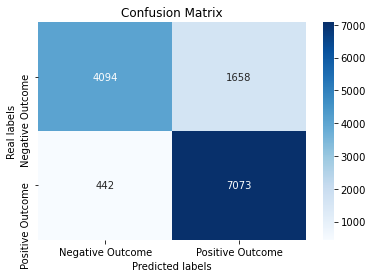

In [537]:
accuracy = produce_confusion('Positive Outcome', 'Negative Outcome', X_cat_test, 'y_pred', y_cat_test)

Once again, we have high recall and accuracy, which as we discussed in the dog classification section, is highly important for this dataset.

In [538]:
for i in [X_cat_train, X_cat_test]:
    try:
        i.drop('y_pred', axis = 1, inplace = True)
    except:
        print('y_pred dropped')

### 5 outcome SVM

Next, I once again, used SVM to classify the data on 5 outcomes: Adoption, Return to Owner, Foster, Euthanised and Transferred.

These datasets no longer require further cleaning and so I just made a copy of the original datasets.

In [539]:
## Create test and train datasets
X_dog_train2 = dog_train.copy()
X_dog_test2 = dog_test.copy()
X_cat_train2 = cat_train.copy()
X_cat_test2 = cat_test.copy()

In [540]:
## Pick x and y
y_dog_train2 = X_dog_train2['Outcome Type']
X_dog_train2 = X_dog_train2[['Age in days upon income', 'Neutered', 'Mix',
       'itype_Euthanasia Request', 'itype_Owner Surrender',
       'itype_Public Assist', 'itype_Stray', 'icond_Medical', 'icond_Normal',
       'icond_Other', 'sex_Male', 'bcat_Herding', 'bcat_Hound', 'bcat_Racing',
       'bcat_Sporting', 'bcat_Terrier', 'bcat_Companion', 'bcat_Working',
       'size_Large', 'size_Medium', 'size_Small', 'size_Toy', 'ccat_Dark',
       'ccat_Light', 'ccat_Merle', 'ccat_Red/Orangeish']]

In [541]:
y_dog_test2 = X_dog_test2['Outcome Type']
X_dog_test2 = X_dog_test2[['Age in days upon income', 'Neutered', 'Mix',
       'itype_Euthanasia Request', 'itype_Owner Surrender',
       'itype_Public Assist', 'itype_Stray', 'icond_Medical', 'icond_Normal',
       'icond_Other', 'sex_Male', 'bcat_Herding', 'bcat_Hound', 'bcat_Racing',
       'bcat_Sporting', 'bcat_Terrier', 'bcat_Companion', 'bcat_Working',
       'size_Large', 'size_Medium', 'size_Small', 'size_Toy', 'ccat_Dark',
       'ccat_Light', 'ccat_Merle', 'ccat_Red/Orangeish']]

Once again I used trial and error however, the parameters did not change.

In [542]:
## model SVM
dog_model2 = SVC(gamma= 0.5             #0.5
              , kernel='rbf'
              , C= 0.1)                 #0.1)
dog_model2.fit(X_dog_train2, y_dog_train2)

SVC(C=0.1, gamma=0.5)

In [543]:
## Predict on train
X_dog_train2['y_pred'] = dog_model2.predict(X_dog_train2)

In [544]:
from sklearn.metrics import classification_report

The accuracy score is relatively high given 5 outcomes, a random guess would give you 0.2 accuracy.

In [545]:
accuracy_score(X_dog_train2['y_pred'], y_dog_train2)

0.6222885729539478

The adoption and foster scores are relatively good, and although euthanasia is giving us a low recall, that is positive in our context as it gives dogs a chance at life. Return to Owner and transfer however are not trustworthy and should be ignored.

Although this is not a great model for 5 outcomes, it does give use a model that can be used to see if an animal should be advertised for adoption or foster.

In [546]:
target_names = ['Adoption', 'Return to Owner', 'Transfer', 'Foster', 'Euthanasia']
print(classification_report(y_dog_train2, X_dog_train2['y_pred'], target_names=target_names))

C:\Users\lhall\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

       Adoption       0.61      0.90      0.73     21121
Return to Owner       1.00      0.00      0.00      1241
       Transfer       0.00      0.00      0.00      3352
         Foster       0.63      0.60      0.61     14026
     Euthanasia       0.66      0.38      0.49     10833

       accuracy                           0.62     50573
      macro avg       0.58      0.38      0.37     50573
   weighted avg       0.60      0.62      0.58     50573



In [547]:
## Predict on test
X_dog_test2['y_pred'] = dog_model2.predict(X_dog_test2)

This is a good test accuracy score as it is very close to the train score. This means the model is not overfitted.

In [548]:
accuracy_score(X_dog_test2['y_pred'], y_dog_test2)

0.6189595375722543

Once again, these values are almost perfectly in line with the train scores above.

In [549]:
print(classification_report(y_dog_test2, X_dog_test2['y_pred'], target_names=target_names))

C:\Users\lhall\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

       Adoption       0.60      0.90      0.72      8858
Return to Owner       1.00      0.00      0.00       519
       Transfer       0.00      0.00      0.00      1454
         Foster       0.63      0.60      0.62      6123
     Euthanasia       0.66      0.38      0.48      4671

       accuracy                           0.62     21625
      macro avg       0.58      0.38      0.36     21625
   weighted avg       0.59      0.62      0.57     21625



In [550]:
## Same for cat below

In [551]:
y_cat_train2 = X_cat_train2['Outcome Type'].copy()
X_cat_train2 = X_cat_train2[['Age in days upon income',
       'Neutered', 'Mix', 'itype_Euthanasia Request', 'itype_Owner Surrender',
       'itype_Public Assist', 'itype_Stray', 'icond_Medical', 'icond_Normal',
       'icond_Other', 'sex_Male', 'bcat_Long Hair', 'bcat_Short Hair',
       'patt_Brindle', 'patt_Point', 'patt_Solid', 'patt_Striped',
       'ccat_Blue/Greyish', 'ccat_Dark', 'ccat_Light', 'ccat_Red/Orangeish']]

In [552]:
y_cat_test2 = X_cat_test2['Outcome Type'].copy()
X_cat_test2['patt_Brindle'] = 0
X_cat_test2 = X_cat_test2[['Age in days upon income',
       'Neutered', 'Mix', 'itype_Euthanasia Request', 'itype_Owner Surrender',
       'itype_Public Assist', 'itype_Stray', 'icond_Medical', 'icond_Normal',
       'icond_Other', 'sex_Male', 'bcat_Long Hair', 'bcat_Short Hair',
       'patt_Brindle', 'patt_Point', 'patt_Solid', 'patt_Striped',
       'ccat_Blue/Greyish', 'ccat_Dark', 'ccat_Light', 'ccat_Red/Orangeish']]

In [553]:
## model SVM
cat_model2 = SVC(gamma=0.5
              , kernel='rbf'
              , C=0.1)
cat_model2.fit(X_cat_train2, y_cat_train2)

SVC(C=0.1, gamma=0.5)

In [554]:
X_cat_train2['y_pred'] = cat_model2.predict(X_cat_train2)

In [555]:
accuracy_score(X_cat_train2['y_pred'], y_cat_train2)

0.6311615461491344

This report is different to that of dog. Euthanasia is giving very strong results whereas foster is very low for recall.

This may mean that when looking at cats, it may be better to focus on adoption and euthanasia.

In [556]:
print(classification_report(y_cat_train2, X_cat_train2['y_pred'], target_names=target_names))

C:\Users\lhall\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

       Adoption       0.55      0.89      0.68     11327
Return to Owner       0.00      0.00      0.00      1159
       Transfer       0.00      0.00      0.00      4564
         Foster       0.56      0.12      0.19      1679
     Euthanasia       0.75      0.75      0.75     12290

       accuracy                           0.63     31019
      macro avg       0.37      0.35      0.33     31019
   weighted avg       0.53      0.63      0.56     31019



In [557]:
X_cat_test2['y_pred'] = cat_model2.predict(X_cat_test2)

Once again, this test score is almost exactly the same as the training score.

In [558]:
accuracy_score(X_cat_test2['y_pred'], y_cat_test2)

0.6311901711012287

In [559]:
print(classification_report(y_cat_test2, X_cat_test2['y_pred'], target_names=target_names))

C:\Users\lhall\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

       Adoption       0.55      0.89      0.68      4846
Return to Owner       0.00      0.00      0.00       528
       Transfer       0.00      0.00      0.00      1949
         Foster       0.56      0.13      0.21       720
     Euthanasia       0.75      0.76      0.76      5224

       accuracy                           0.63     13267
      macro avg       0.37      0.36      0.33     13267
   weighted avg       0.53      0.63      0.56     13267



## Random Forest Regression

After attempting linear and polynomial regression and getting R^2 values of less than 20%, I learned about Random Forest Regression. It turned out to be the best model given this data set.

As outliers badly affected my R^2 value, I removed them from my dataset. This involved any dogs who have spent more than 100 days at the shelter, however this does mean that, we would find it very difficult to assess if any dog would stay more than that time frame.

In [560]:
## Remove outliers
dog_train = dog_train[dog_train['Time Spent in Shelter'] < 100]
dog_test = dog_test[dog_test['Time Spent in Shelter'] < 100]

These are the columns used for regression modelling. I have left in the linear and polynomial regression columns in case of future use.

In [561]:
## Not used-for linear and poly regression
dog_cols = ['Age in days upon income',
       'Neutered', 
        'Mix', 
        #'itype_Euthanasia Request', 
        #'itype_Owner Surrender',
       'itype_Public Assist', 
        #'itype_Stray', 
        #'icond_Medical', 
        #'icond_Normal',
        #'icond_Other', 
        'sex_Male', 
        #'bcat_Herding', 
        #'bcat_Hound', 
        #'bcat_Racing',
       'bcat_Sporting', 
        #'bcat_Terrier', 
        'bcat_Companion', 
        'bcat_Working',
       'size_Large', 
        'size_Medium', 
        #'size_Small', 
        #'size_Toy', 
        'ccat_Dark',
       'ccat_Light', 
        #'ccat_Merle', 
        'ccat_Red/Orangeish'
       ]

In [562]:
## Cat columns for random forest regression
cat_cols = ['Age in days upon income',
       'Neutered', 
        'Mix',
        'itype_Euthanasia Request',
        'itype_Owner Surrender',
       'itype_Public Assist', 
        'itype_Stray', 
        'icond_Medical', 
        'icond_Normal',
       'icond_Other', 
        'sex_Male', 
        'bcat_Long Hair', 
        'bcat_Short Hair',
       'patt_Brindle', 
        'patt_Point', 
        'patt_Solid', 
        'patt_Striped',
       'ccat_Blue/Greyish', 
        'ccat_Dark', 
        'ccat_Light', 
        'ccat_Red/Orangeish']

In [563]:
## Dog columns for random forest regression
cols4 = ['Age in days upon income',
       'Neutered', 
        'Mix', 
        'itype_Euthanasia Request', 
        'itype_Owner Surrender',
       'itype_Public Assist', 
        'itype_Stray', 
        'icond_Medical', 
        'icond_Normal',
        'icond_Other', 
        'sex_Male', 
        'bcat_Herding', 
        'bcat_Hound', 
        'bcat_Racing',
       'bcat_Sporting', 
        'bcat_Terrier', 
        'bcat_Companion', 
        'bcat_Working',
       'size_Large', 
        'size_Medium', 
        'size_Small', 
        'size_Toy', 
        'ccat_Dark',
       'ccat_Light', 
        'ccat_Merle', 
        'ccat_Red/Orangeish'
       ]

Only including data of adopted dogs, also helped the model significantly. Hence this model should only be used to see how long it would take for that dog to be adopted.

Our x and y columns are also chosen here.

In [564]:
## Only using adoption data for testing how long it should take and picking feature cols.
def fix_training_for_pr(df, cols):
    '''Function to only provide adoption data and create X and y datasets.
    
    parameters:
    - df: dataframe of dog or cat dataset
    - cols: list of string values to be used for modelling
    
    output:
    X and y datasets of adopted animals'''
    X = df[df['Outcome Type'].isin(['Adoption'])].copy()  #,'Return to Owner','Foster'
    y = X['Time Spent in Shelter']
    X = X[cols]
    return X, y

In [565]:
X_dog_train_lr, y_dog_train_lr = fix_training_for_pr(dog_train, cols4)

In [566]:
X_dog_test_lr, y_dog_test_lr = fix_training_for_pr(dog_test, cols4)

In [567]:
X_cat_train_lr, y_cat_train_lr = fix_training_for_pr(cat_train, cat_cols)

In [568]:
## pattern brindle does not exist in test
cat_test['patt_Brindle'] = 0
X_cat_test_lr, y_cat_test_lr = fix_training_for_pr(cat_test, cat_cols)

In [569]:
## Running the regressor
dog_regressor = RandomForestRegressor(n_estimators = 500, random_state = 0, max_leaf_nodes = 80)#,max_depth = 5)
dog_results = dog_regressor.fit(X_dog_train_lr, y_dog_train_lr)
dog_pred = dog_regressor.predict(X_dog_train_lr)
dog_pred_test = dog_regressor.predict(X_dog_test_lr)
print(f'Train: {dog_results.score(X_dog_train_lr, y_dog_train_lr)}')
print(f'Test: {dog_results.score(X_dog_test_lr, y_dog_test_lr)}')
np.sum((y_dog_test_lr-dog_pred_test)**2)

Train: 0.30051432865398586
Test: 0.24674703092663874


1856915.6377096232

In [570]:
cat_regressor = RandomForestRegressor(n_estimators = 100, random_state = 0, max_leaf_nodes = 30)
cat_results = cat_regressor.fit(X_cat_train_lr, y_cat_train_lr)
cat_pred = cat_regressor.predict(X_cat_train_lr)
cat_pred_test = cat_regressor.predict(X_cat_test_lr)
print(f'Train: {cat_results.score(X_cat_train_lr, y_cat_train_lr)}')
print(f'Test: {cat_results.score(X_cat_test_lr, y_cat_test_lr)}')

Train: 0.30633260623469905
Test: 0.25888971514932957


### Miscellaneous regression graphs

This plot shows that the count of the difference between real and prediction from the regression model does have a normal distribution, with the majority being around zero. 

The issue being that it tends quickly towards very small values, meaning it is skewed.

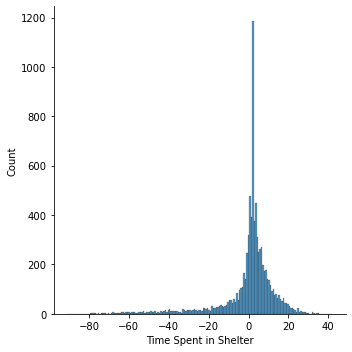

In [571]:
sns.displot(dog_pred_test- y_dog_test_lr)

This is a scatter plot showing the data used for regression modelling and it's lack of correlation. This is highly likely to be the reason for such a low correlation coefficient with the random forest regressor and other regression models.

Text(0, 0.5, 'Time Spent in Shelter')

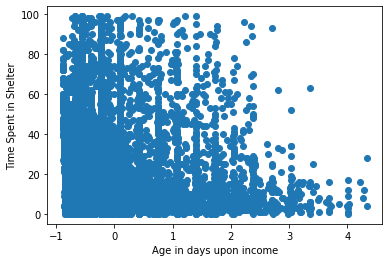

In [612]:
## Age in days against time spent in shelter. 
## No correlation implies no linear regression.
plt.scatter(X_dog_train_lr['Age in days upon income'], y_dog_train_lr)
plt.xlabel('Age in days upon income')
plt.ylabel('Time Spent in Shelter')

## Final Function

Finally, I have built the final function. This function asks and takes in data about a person's dog or cat and feeds them to the models above. It then gives you the outcome and if it were not for the inaccuracy of the regression model, would have also given an amount of time.

In [598]:
def dog_or_cat():
    '''Function requesting input and calling another function.
    
    output:
    calls another function given correct input or loops back'''
    global dict_
    dict_ = dict()
    animal = input('Dog or cat?')
    animal = animal.title()
    if animal == 'Dog':
        dog_function()
    elif animal == 'Cat':
        cat_function()
    else:
        print('Please pick either dog or cat.')
        dog_or_cat()

### Dog

In [577]:
def age_calc():
    '''Function requesting input and adding inputted value to dataframe, if input invalid, loop back.
    
    output:
    inputs value into dataframe given correct input or loops back'''
    age = input('Age (5 years/6 months/ 14 days): ')
    if 'year' in age:
        dict_['Age in days upon income'] = int(re.sub(r'\syear[s]?', "", age))*365
    elif 'month' in age:
        dict_['Age in days upon income'] = int(re.sub(r'\smonth[s]?', "", age))*30
    elif 'week' in age:
        dict_['Age in days upon income'] = int(re.sub(r'\sweek[s]?','', age))*7
    elif 'day' in age:
        dict_['Age in days upon income'] = int(re.sub(r'\sday[s]?','', age))
    else:
        print('Write age in 13 years, 6 months etc')
        age_calc()

In [578]:
def neutered_func():
    '''Function requesting input and adding inputted value to dataframe, if input invalid, loop back.
    
    output:
    inputs value into dataframe given correct input or loops back'''
    boolean = input('Are they neutered (yes/no): ')
    if boolean.lower() == 'yes':
        dict_['Neutered'] = 1
    elif boolean.lower() == 'no':
        dict_['Neutered'] = 0
    else:
        print('Error please input yes or no.')
        neutered_func()

In [579]:
def mix_func():
    '''Function requesting input and adding inputted value to dataframe, if input invalid, loop back.
    
    output:
    inputs value into dataframe given correct input or loops back'''
    boolean = input('Are they a cross breed? (yes/no): ')
    if boolean.lower() == 'yes':
        dict_['Mix'] = 1
    elif boolean.lower() == 'no':
        dict_['Mix'] = 0
    else:
        print('Error please input yes or no.')
        mix_func()

In [580]:
def itype_func():
    '''Function requesting input and adding inputted value to dataframe, if input invalid, loop back.
    
    output:
    inputs value into dataframe given correct input or loops back'''
    itype = input('(Stray, Owner Surrender, Public Assist, Euthanasia Request, Abandoned):')
    itype = itype.title()
    dict_['itype_Stray'] = 0
    dict_['itype_Owner Surrender'] = 0
    dict_['itype_Public Assist'] = 0
    dict_['itype_Euthanasia Request'] = 0
    if itype == 'Stray':
        dict_['itype_Stray'] = 1
    elif itype == 'Owner Surrender':
        dict_['itype_Owner Surrender'] = 1
    elif itype == 'Public Assist':
        dict_['itype_Public Assist'] = 1
    elif itype == 'Euthanasia Request':
        dict_['itype_Euthanasia Request'] = 1
    elif itype == 'Abandoned':
        pass
    else:
        print('Error print one of the given inputs')
        itype_func()

In [581]:
def icond_func():
    '''Function requesting input and adding inputted value to dataframe, if input invalid, loop back.
    
    output:
    inputs value into dataframe given correct input or loops back'''
    icond = input('Normal, Medical, Other, Behavior: ')
    icond = icond.title()
    dict_['icond_Normal'] = 0
    dict_['icond_Medical'] = 0
    dict_['icond_Other'] = 0
    if icond == 'Normal':
        dict_['icond_Normal'] = 1
    elif icond == 'Medical':
        dict_['icond_Medical'] = 1
    elif icond == 'Other':
        dict_['icond_Other'] = 1
    elif icond == 'Behavior':
        pass
    else:
        print('Error print one of the given inputs')
        icond_func()

In [582]:
def m_or_f():
    '''Function requesting input and adding inputted value to dataframe, if input invalid, loop back.
    
    output:
    inputs value into dataframe given correct input or loops back'''
    gender = input('Male or Female:')
    if gender.lower() == 'male':
        dict_['sex_Male'] = 1
    elif gender.lower() == 'female':
        dict_['sex_Male'] = 0
    else:
        print('Error please input male or female.')
        m_or_f()

In [583]:
def breed_dog_func():
    '''Function requesting input and adding inputted value to dataframe, if input invalid, loop back.
    
    output:
    inputs value into dataframe given correct input or loops back'''
    breed = input('What breed is your dog:')
    breed = breed.title()
    dict_['bcat_Herding'] = 0
    dict_['bcat_Hound'] = 0
    dict_['bcat_Terrier'] = 0
    dict_['bcat_Working'] = 0
    dict_['bcat_Sporting'] = 0
    dict_['bcat_Companion'] = 0
    dict_['bcat_Racing'] = 0
    dict_['size_Toy'] = 0
    dict_['size_Small'] = 0
    dict_['size_Medium'] = 0
    dict_['size_Large'] = 0
    if breed in Herding_dogs:
        dict_['bcat_Herding'] = 1
        size_breed_func(breed)
    elif breed in Hound_dogs:
        dict_['bcat_Hound'] = 1
        size_breed_func(breed)
    elif breed in Terriers:
        dict_['bcat_Terrier'] = 1
        size_breed_func(breed)
    elif breed in Working_dogs:
        dict_['bcat_Working'] = 1
        size_breed_func(breed)
    elif breed in Sporting_dogs:
        dict_['bcat_Sporting'] = 1
        size_breed_func(breed)
    elif breed in Companions:
        dict_['bcat_Companion'] = 1
        size_breed_func(breed)
    elif breed in Racing_dogs:
        dict_['bcat_Racing'] = 1
        size_breed_func(breed)
    elif breed in Bull:
        size_breed_func(breed)
    else:
        print('This dog is not a registered breed in our database')
        breed_dog_cat_func()

In [584]:
def breed_dog_cat_func():
    '''Function requesting input and adding inputted value to dataframe, if input invalid, loop back.
    
    output:
    inputs value into dataframe given correct input or loops back'''
    breed = input('Categorise your pets breed (Companion, Herding, Hound, Terrier, Working, Sporting, Bull, Racing):')
    if breed.title() == 'Herding':
        dict_['bcat_Herding'] = 1
    elif breed.title() == 'Hound':
        dict_['bcat_Hound'] = 1
    elif breed.title() == 'Terrier':
        dict_['bcat_Terrier'] = 1
    elif breed.title() == 'Working':
        dict_['bcat_Working'] = 1
    elif breed.title() == 'Sporting':
        dict_['bcat_Sporting'] = 1
    elif breed.title() == 'Companion':
        dict_['bcat_Companion'] = 1
    elif breed.title() == 'Racing':
        dict_['bcat_Racing'] = 1
    elif breed.title() == 'Bull':
        pass
    else:
        print('Please pick a category from the list.')
        breed_dog_cat_func()

In [585]:
def size_breed_func(breed):
    '''Function requesting input and adding inputted value to dataframe, if input invalid, loop back.
    
    output:
    inputs value into dataframe given correct input or loops back'''
    if breed in toy:
        dict_['size_Toy'] = 1
    elif breed in small:
        dict_['size_Small'] = 1
    elif breed in medium:
        dict_['size_Medium'] = 1
    elif breed in large:
        dict_['size_Large'] = 1
    elif breed in giant:
        pass

In [586]:
def size_func():
    '''Function requesting input and adding inputted value to dataframe, if input invalid, loop back.
    
    output:
    inputs value into dataframe given correct input or loops back'''
    size = input('What size is your dog: ')
    if size.title() == 'Toy':
        dict_['size_Toy'] = 1
    elif size.title() == 'Small':
        dict_['size_Small'] = 1
    elif size.title() == 'Medium':
        dict_['size_Medium'] = 1
    elif size.title() == 'Large':
        dict_['size_Large'] = 1
    elif size.title() == 'Giant':
        pass
    else:
        print('Please pick a category from the list.')
        size_func()

In [587]:
def dog_color_func():
    '''Function requesting input and adding inputted value to dataframe, if input invalid, loop back.
    
    output:
    inputs value into dataframe given correct input or loops back'''
    color = input('What is the main colour of your dog:')
    dict_['ccat_Dark'] = 0
    dict_['ccat_Light'] = 0
    dict_['ccat_Merle'] = 0
    dict_['ccat_Red/Orangeish'] = 0
    if color.title() in dark_dog:
        dict_['ccat_Dark'] = 1
    elif color.title() in light_dog:
        dict_['ccat_Light'] = 1
    elif color.title() in merle_dog:
        dict_['ccat_Merle'] = 1
    elif color.title() in red_orange_dog:
        dict_['ccat_Red/Orangeish'] = 1
    elif color.title() in blue_grey_dog:
        pass
    else:
        print('This color is not registered in our database.')
        dog_color_cat_func()

In [588]:
def dog_color_cat_func():
    '''Function requesting input and adding inputted value to dataframe, if input invalid, loop back.
    
    output:
    inputs value into dataframe given correct input or loops back'''
    color = input('Please categorise your dogs color (Dark, Light, Merle, Red/Orange, Blue/Grey): ')
    color = color.title()
    if color == 'Dark':
        dict_['ccat_Dark'] = 1
    elif color == 'Light':
        dict_['ccat_Light'] = 1
    elif color == 'Merle':
        dict_['ccat_Merle'] = 1
    elif color == 'Red/Orange':
        dict_['ccat_Red/Orangeish'] = 1
    elif color == 'Blue/Grey':
        pass
    else:
        print('Please pick a category from the list.')
        dog_color_cat_func()

In [589]:
def outcome_func(pred):
    '''Function matching model output to value and printing.
    
    output:
    prints a string'''
    if pred == 'Adopted':
        print('Adopted')
    elif pred == 'Return to Owner':
        print('Returned to owner')
    elif pred == 'Foster':
        print('Fostered')
    elif pred == 'Transfer':
        print('Transferred')
    elif pred == 'Euthanasia':
        print('Euthanized')
    else:
        print('Something has gone wrong.')

This function brings together everything taken in from the functions above and turns it into a single line database. It then feeds this database to the 2 and 5 outcome models.

In [590]:
def dog_function():
    '''Function calling other functions and creating a dataframe from functions outputs. Finally printing it's own output.
    
    output:
    prints output based on models predicted values'''
    age_calc()
    neutered_func()
    mix_func()
    itype_func()
    icond_func()
    m_or_f()
    breed_dog_func()
    dog_color_func()
    
    df = pd.DataFrame([dict_])
    dog_pred = dog_model.predict(df)
    dog_pred2 = dog_model2.predict(df)
    if dog_pred == 1 and dog_pred2 in ['Adopted', 'Foster', 'Return to Owner']:
        print('This dog will either be adopted, fostered or returned to their owner.')
        print('This dog will likely be:')
        outcome_func(dog_pred2)
        ## If regression model had been more accurate, I would have used this
        #print('If this dog was to be adopted it would take:')
        #df['Age in days upon income'] = scaler_dog.transform(df[scaler_dog_cols])
        #dog_time_pred = dog_regressor.predict(df)
        #print(f'{round(dog_time_pred[0],0)} days.')
        #return df
    else:
        print('Unfortunately, this dog will have to be transferred or euthanised.')

### Cat

In [591]:
def breed_cat_func():
    '''Function requesting input and adding inputted value to dataframe, if input invalid, loop back.
    
    output:
    inputs value into dataframe given correct input or loops back'''
    breed = input('What breed is your cat:')
    breed = breed.title()
    dict_['bcat_Long Hair'] = 0
    dict_['bcat_Short Hair'] = 0
    if breed in short_hair:
        dict_['bcat_Short Hair'] = 1
    elif breed in long_hair:
        dict_['bcat_Long Hair'] = 1
    elif breed in hairless:
        pass
    else:
        print('This cat is not a registered breed in our database')
        breed_cat_cat_func()

In [592]:
def breed_cat_cat_func():
    '''Function requesting input and adding inputted value to dataframe, if input invalid, loop back.
    
    output:
    inputs value into dataframe given correct input or loops back'''
    breed = input('Categorise your pets breed (Long Hair, Short Hair, Hairless):')
    if breed.title() == 'Long Hair':
        dict_['bcat_Long Hair'] = 1
    elif breed.title() == 'Short Hair':
        dict_['bcat_Short Hair'] = 1
    elif breed.title() == 'Hairless':
        pass
    else:
        print('Please pick a category from the list.')
        breed_cat_cat_func()

In [593]:
def cat_color_func():
    '''Function requesting input and adding inputted value to dataframe, if input invalid, loop back.
    
    output:
    inputs value into dataframe given correct input or loops back'''
    color = input('What is the main colour of your cat:')
    dict_['ccat_Dark'] = 0
    dict_['ccat_Light'] = 0
    dict_['ccat_Blue/Greyish'] = 0
    dict_['ccat_Red/Orangeish'] = 0
    if color.title() in dark_cat:
        dict_['ccat_Dark'] = 1
    elif color.title() in light_cat:
        dict_['ccat_Light'] = 1
    elif color.title() in blue_grey_cat:
        dict_['ccat_Blue/Greyish'] = 1
    elif color.title() in red_orange_cat:
        dict_['ccat_Red/Orangeish'] = 1
    elif color.title() in black_orange_white_cat:
        pass
    else:
        print('This color is not registered in our database.')
        cat_color_cat_func()

In [594]:
def cat_color_cat_func():
    '''Function requesting input and adding inputted value to dataframe, if input invalid, loop back.
    
    output:
    inputs value into dataframe given correct input or loops back'''
    color = input("Please categorise your cat's color (Dark, Light, Black Orange and White, Red/Orange, Blue/Grey): ")
    color = color.title()
    if color == 'Dark':
        dict_['ccat_Dark'] = 1
    elif color == 'Light':
        dict_['ccat_Light'] = 1
    elif color == 'Blue/Grey':
        dict_['ccat_Blue/Greyish'] = 1
    elif color == 'Red/Orange':
        dict_['ccat_Red/Orangeish'] = 1
    elif color == 'Black Orange And White':
        pass
    else:
        print('Please pick a category from the list.')
        dog_color_cat_func()

In [595]:
def cat_pattern():
    '''Function requesting input and adding inputted value to dataframe, if input invalid, loop back.
    
    output:
    inputs value into dataframe given correct input or loops back'''
    dict_['patt_Brindle'] = 0
    dict_['patt_Point'] = 0
    dict_['patt_Solid'] = 0
    dict_['patt_Striped'] = 0
    pattern = input("Please categorise your cat's fur pattern (Brindle, Point, Solid,  Striped, 2 color): ")
    pattern = pattern.title()
    if pattern == 'Brindle':
        dict_['patt_Brindle'] = 1
    elif pattern == 'Point':
        dict_['patt_Point'] = 1
    elif pattern == 'Solid':
        dict_['patt_Solid'] = 1
    elif pattern == 'Striped': 
        dict_['patt_Striped'] = 1
    elif pattern == '2 color':
        pass
    else:
        print('Please pick a category from the list.')
        cat_pattern()

In [596]:
def cat_function():
    '''Function calling other functions and creating a dataframe from functions outputs. Finally printing it's own output.
    
    output:
    prints output based on models predicted values'''
    age_calc()
    neutered_func()
    mix_func()
    itype_func()
    icond_func()
    m_or_f()
    breed_cat_func()
    cat_color_func()
    cat_pattern()
    
    df = pd.DataFrame([dict_])
    cat_pred = cat_model.predict(df)
    cat_pred2 = cat_model2.predict(df)
    if cat_pred == 1 and cat_pred2 in ['Adopted', 'Foster', 'Return to Owner']:
        print('This cat will either be adopted, fostered or returned to the owner.')
        print('It will likely be:')
        outcome_func(cat_pred2)
        ## If regression had been more accurate, I would have used this.
        #print('If this cat was to be adopted it would take:')
        #df['Age in days upon income'] = scaler_cat.transform(df[scaler_cat_cols])
        #cat_time_pred = cat_regressor.predict(df)
        #print(f'{int(cat_time_pred[0])} days.')
        #return df
    else:
        print('Unfortunately, this cat will have to be transferred or euthanised.')
        print('It will likely be:')
        outcome_func(cat_pred2)

## Run code

You can run the code here and see the data below that is fed to the models.

In [609]:
dog_or_cat()

Dog or cat? dog
Age (5 years/6 months/ 14 days):  4 years
Are they neutered (yes/no):  no
Are they a cross breed? (yes/no):  no
(Stray, Owner Surrender, Public Assist, Euthanasia Request, Abandoned): stray
Normal, Medical, Other, Behavior:  normal
Male or Female: male
What breed is your dog: labrador retriever
What is the main colour of your dog: chocolate


This dog will either be adopted, fostered or returned to their owner.
This dog will likely be:
Returned to owner


In [604]:
dict_

{'Age in days upon income': 1095,
 'Neutered': 0,
 'Mix': 0,
 'itype_Stray': 1,
 'itype_Owner Surrender': 0,
 'itype_Public Assist': 0,
 'itype_Euthanasia Request': 0,
 'icond_Normal': 1,
 'icond_Medical': 0,
 'icond_Other': 0,
 'sex_Male': 1,
 'bcat_Herding': 0,
 'bcat_Hound': 0,
 'bcat_Terrier': 0,
 'bcat_Working': 0,
 'bcat_Sporting': 1,
 'bcat_Companion': 0,
 'bcat_Racing': 0,
 'size_Toy': 0,
 'size_Small': 0,
 'size_Medium': 0,
 'size_Large': 1,
 'ccat_Dark': 0,
 'ccat_Light': 1,
 'ccat_Merle': 0,
 'ccat_Red/Orangeish': 0}

## Conclusion

From this project, I have learned a lot, not only about the behaviours of people towards pets, but also about new data science techniques and model improvement. 

As shown by my models, although one may be able to predict a dog or cat's outcome based on its provided data, it is a lot more difficult (even impossible) to predict the length of time it would spend in the shelter. 